## Shape analysis of species ranges

In this notebook we consider some spatial properties of the ranges of each species of plant in a taxonomic class. The observations of each species can be considered as a spatial point set. The methods used here are spatial descriptive statistics.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pathlib import Path
import cartopy.crs as ccrs
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import haversine_distances
from scipy.spatial import distance_matrix

Select a taxonomic class for analysis.

In [2]:
#pclass = "Pinopsida"
pclass = "Polypodiopsida"

These are some geophysical constants that we will need below.

In [3]:
earth_radius_m = 6371000
earth_radius_km = earth_radius_m / 1000
earth_circumference_km = 40075
land_area = 149 * 10^6

In [5]:
pa = Path("/Users/liangqi/Library/Mobile Documents/com~apple~CloudDocs/Stats-504/inaturalist")
fn = pa / ("Plantae_%s.csv.gz" % pclass)

In [6]:
v = ["species", "decimalLatitude", "decimalLongitude", "eventDate"]
df = pd.read_csv(fn, parse_dates=["eventDate"], usecols=v)
df = df.dropna()
df = df.query("eventDate >= 20150101")
df.head()

,species,decimalLatitude,decimalLongitude,eventDate
0,Amauropelta noveboracensis,41.648238,-72.278863,2016-05-28 15:12:00
1,Sceptridium dissectum,35.826566,-80.009607,2016-08-12 17:13:00
3,Myriopteris covillei,32.209233,-110.534942,2017-08-06 14:26:58
4,Dryopteris marginalis,42.374007,-76.876130,2018-03-20 14:18:00
5,Osmundastrum cinnamomeum,46.614966,-84.474779,2018-06-13 18:01:39


For this analysis we will only consider species with at least 1000 observations.

In [7]:
df["n"] = df.groupby("species").transform("size")
df = df.query("n>=1000")

To visualize the results of this analysis, we will make maps showing the locations of species with the least and greatest levels of spatial dispersion.

In [8]:
def map_species(sn):
    dx = df.query("species=='{}'".format(sn))
    plt.figure()
    plt.figure(figsize=(9, 7.25))
    ax = plt.axes([0.05, 0.05, 0.84, 0.88], projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines()
    ax.set_extent([0, 310, -60, 80])
    
    plt.scatter(dx["decimalLongitude"], dx["decimalLatitude"], s=8, alpha=0.1, color="red", 
                transform=ccrs.Geodetic(), rasterized=True)
    plt.title(sn)
    plt.show()

To calculate distances below, we will need to have the latitude and longitude of each observation in radians.

In [9]:
df["lonrad"] = np.pi * df["decimalLongitude"] / 180
df["latrad"] = np.pi * df["decimalLatitude"] / 180

We will be calculating some circular statistics below, for which we need these quantities.

In [10]:
df["lonrad_sin"] = np.sin(df["lonrad"])
df["lonrad_cos"] = np.cos(df["lonrad"])

The circular mean and circular variance are based on these means:

In [11]:
df["lonrad_cos_mean"] = df.groupby("species")["lonrad_cos"].transform(np.mean)
df["lonrad_sin_mean"] = df.groupby("species")["lonrad_sin"].transform(np.mean)

/var/folders/1m/g_2xpnh912g613fymwqbt4gr0000gn/T/ipykernel_52894/2482123140.py:1: FutureWarning: The provided callable <function mean at 0x10ae4f100> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df["lonrad_cos_mean"] = df.groupby("species")["lonrad_cos"].transform(np.mean)
/var/folders/1m/g_2xpnh912g613fymwqbt4gr0000gn/T/ipykernel_52894/2482123140.py:2: FutureWarning: The provided callable <function mean at 0x10ae4f100> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df["lonrad_sin_mean"] = df.groupby("species")["lonrad_sin"].transform(np.mean)


Below we calculate the circular variances of the longitude values for each species.

In [12]:
df["lon_var"] = 1 - np.sqrt(df["lonrad_cos_mean"]**2 + df["lonrad_sin_mean"]**2)

The histogram below shows a strong bimodal pattern in the circular variances.

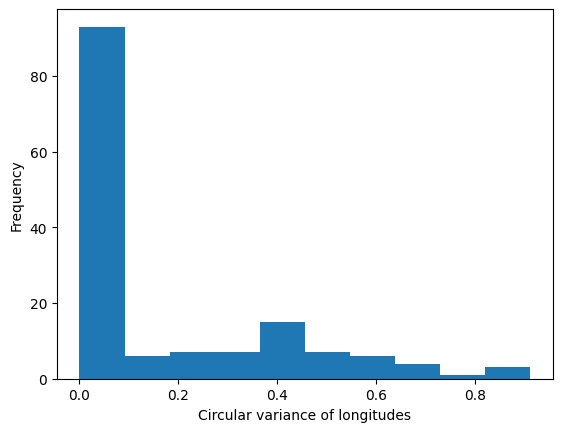

In [13]:
dd = df.groupby("species")["lon_var"].first()
plt.hist(dd)
plt.xlabel("Circular variance of longitudes")
plt.ylabel("Frequency");

The maps below reveal that the species with small longitudinal variances are limited to a single island.

<Figure size 640x480 with 0 Axes>

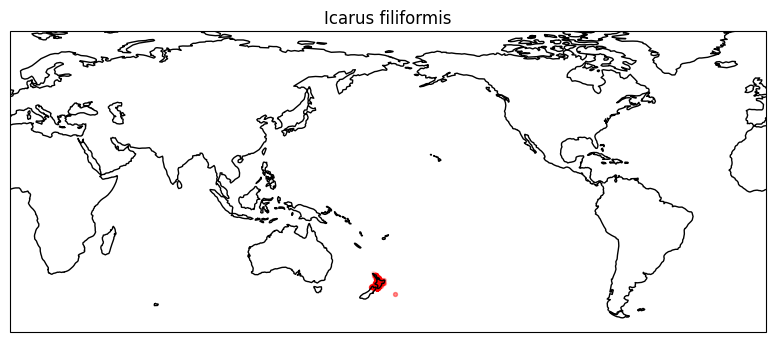

<Figure size 640x480 with 0 Axes>

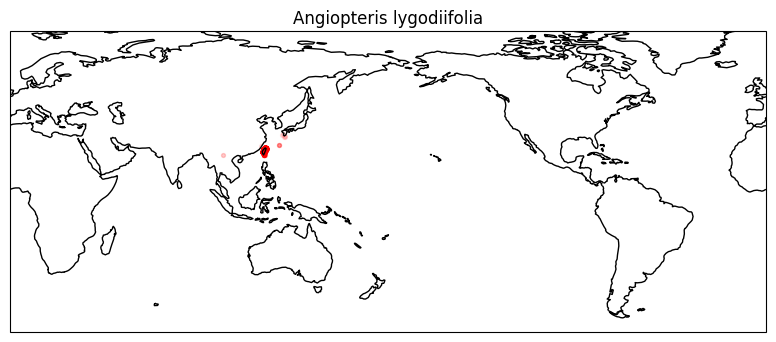

<Figure size 640x480 with 0 Axes>

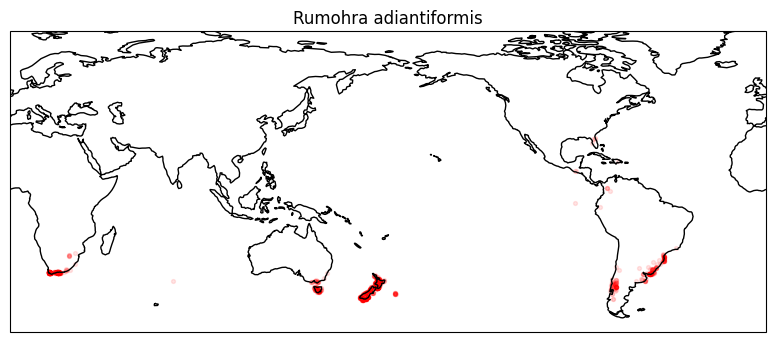

<Figure size 640x480 with 0 Axes>

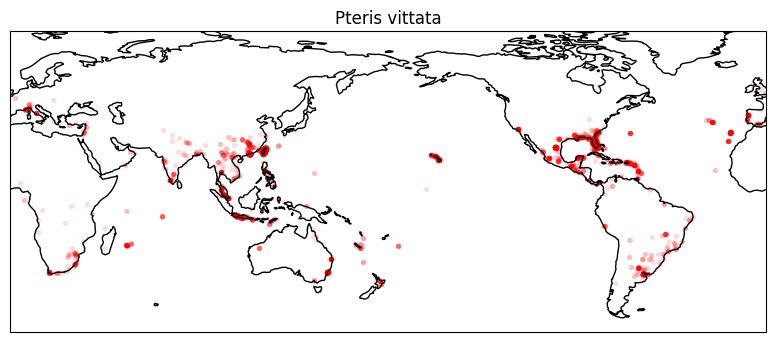

In [14]:
dd = dd.sort_values()

for j in [0, 1, -2, -1]:
    sn = dd.index[j]
    map_species(sn)

Below we calculate the median pairwise distance between pairs of observations of each species.  This is one of the most basic measures of spatial dispersion.

In [15]:
def f(dx):
    n = dx.shape[0]
    m = min(n, 1000)
    ii = np.random.choice(n, m)
    di = earth_radius_km * haversine_distances(dx[["latrad", "lonrad"]].iloc[ii, :])
    ii = np.tril_indices(m)
    return pd.Series({"n": n, "med_dist": np.median(di[ii])})

dd = df.groupby("species").apply(f)

/var/folders/1m/g_2xpnh912g613fymwqbt4gr0000gn/T/ipykernel_52894/1091404308.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dd = df.groupby("species").apply(f)


<Figure size 640x480 with 0 Axes>

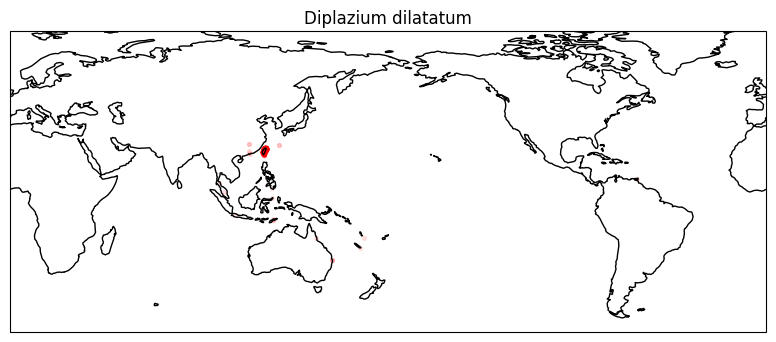

<Figure size 640x480 with 0 Axes>

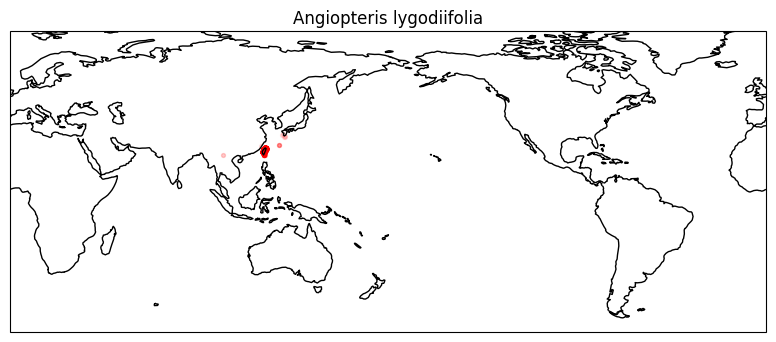

<Figure size 640x480 with 0 Axes>

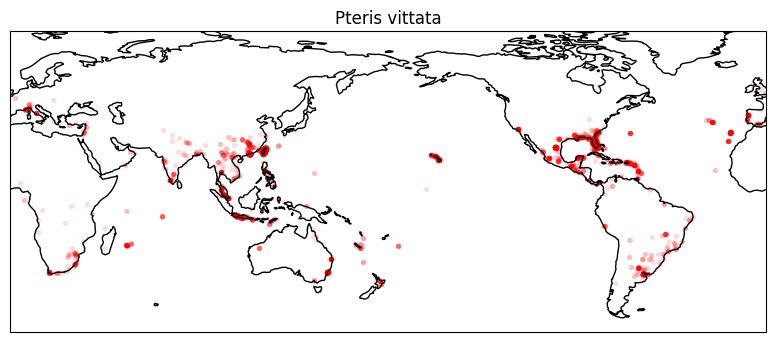

<Figure size 640x480 with 0 Axes>

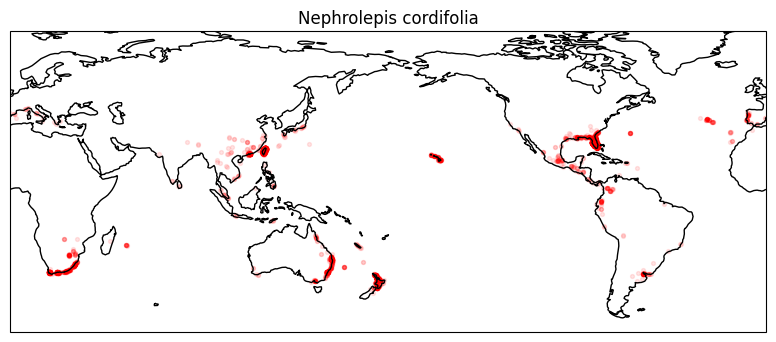

In [16]:
dd = dd.sort_values(by="med_dist")

for i in [0, 1, -2, -1]:
    sn = dd.index[i]
    map_species(sn)

Below we evaluate the empirical CDF (eCDF) of pairwise distances within a species.  The functions are evaluated on a grid of points (defined below as 'dgr'), so that we can analyze them as fixed-length vectors.

In [17]:
dgr = np.square(np.linspace(1, np.sqrt(earth_circumference_km/4), 100))

def f(dx):
    n = dx.shape[0]
    m = min(n, 1000)
    ii = np.random.choice(n, m)
    di = earth_radius_km * haversine_distances(dx[["latrad", "lonrad"]].iloc[ii, :])
    ii = np.tril_indices(m)
    dv = di[ii]
    dv.sort()
    ii = np.searchsorted(dv, dgr)
    return pd.Series({"n": n, "ecdf": ii/len(dv)})

dd = df.groupby("species").apply(f)

/var/folders/1m/g_2xpnh912g613fymwqbt4gr0000gn/T/ipykernel_52894/4069675689.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dd = df.groupby("species").apply(f)


Below we plot the empirical CDFs of pairwise distances for a random subset of the species.

Text(0, 0.5, 'Fraction of pairwise distances')

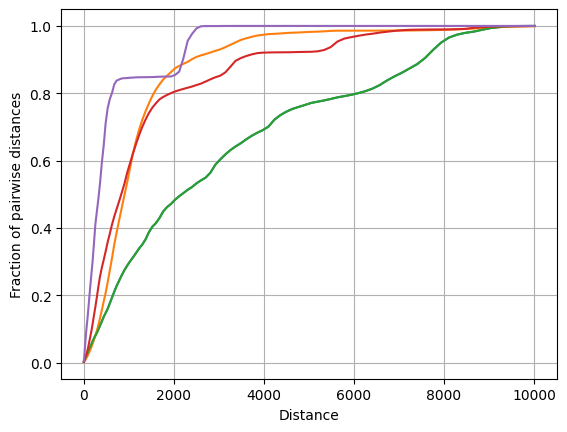

In [18]:
for j in np.random.choice(dd.shape[0], 5):
    plt.plot(dgr, dd["ecdf"].iloc[j], "-")
    plt.grid(True)
plt.xlabel("Distance")
plt.ylabel("Fraction of pairwise distances")

The [correlation dimension](https://en.wikipedia.org/wiki/Correlation_dimension) posits that the fraction $p(\epsilon)$ of pairwise distances that are less than a value $\epsilon > 0$ follow the power law $p(\epsilon) \sim \epsilon^\nu$ for small $\epsilon$.  The value of $\nu$ is the correlation dimension.  

Text(0, 0.5, 'Log fraction of pairwise distances')

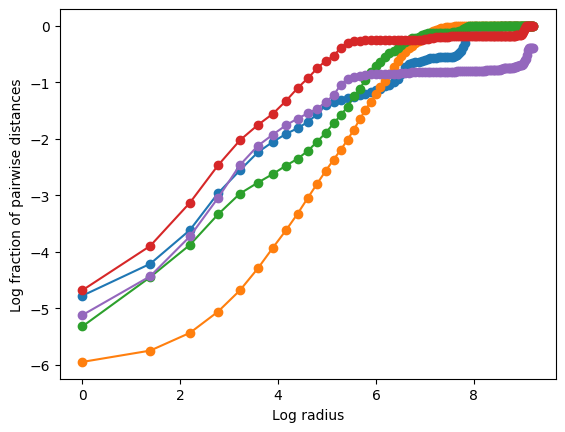

In [19]:
for j in np.random.choice(dd.shape[0], 5):
    plt.plot(np.log(dgr), np.log(dd["ecdf"].iloc[j]), "-o")
plt.xlabel("Log radius")
plt.ylabel("Log fraction of pairwise distances")

Below we estimate the correlation dimension using least squares regression in log/log space.  Most of the species have a correlation dimension that is around 1.

(array([ 2.,  2.,  1., 11., 15., 32., 37., 24., 16.,  9.]),
 array([0.14729653, 0.2589164 , 0.37053628, 0.48215615, 0.59377603,
        0.7053959 , 0.81701578, 0.92863565, 1.04025553, 1.1518754 ,
        1.26349528]),
 <BarContainer object of 10 artists>)

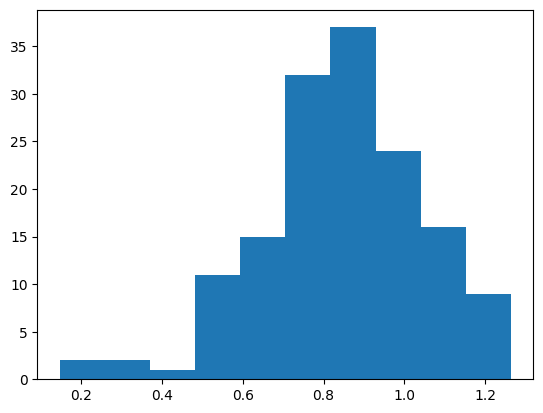

In [20]:
log_dgr = np.log(dgr)
ii = np.flatnonzero((2 <= log_dgr) & (log_dgr <= 6))
log_dgr_res = log_dgr[ii]

def f(ecdf):
    cc = np.cov(log_dgr_res, np.log(ecdf[ii]))
    return cc[0, 1] / cc[0, 0]
    
dd["cor_dim"] = dd["ecdf"].apply(f)
plt.hist(dd["cor_dim"])

Text(0, 0.5, 'Log fraction of pairwise distances')

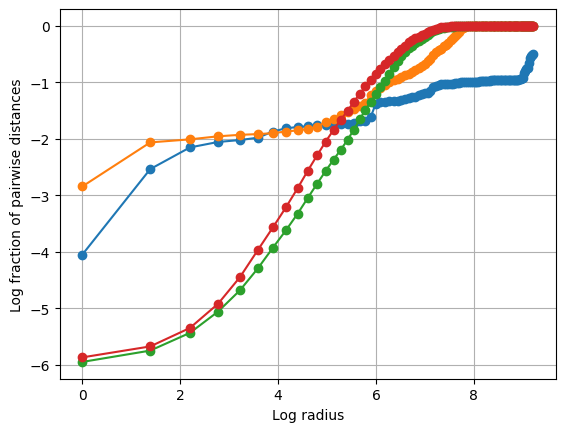

In [21]:
dd = dd.sort_values(by="cor_dim")

for j in [0, 1, -2, -1]:
    plt.plot(np.log(dgr), np.log(dd["ecdf"].iloc[j]), "-o")
plt.grid(True)
plt.xlabel("Log radius")
plt.ylabel("Log fraction of pairwise distances")

<Figure size 640x480 with 0 Axes>

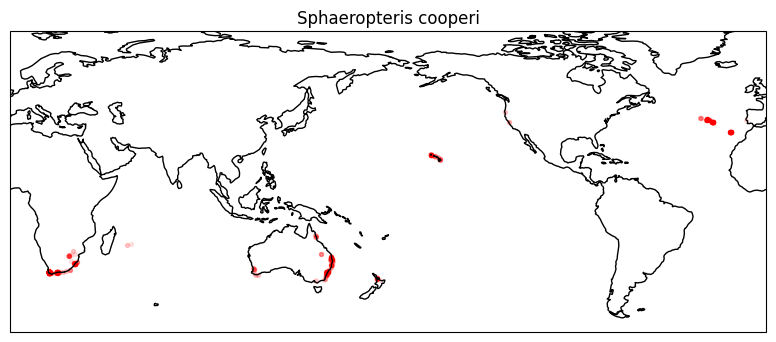

<Figure size 640x480 with 0 Axes>

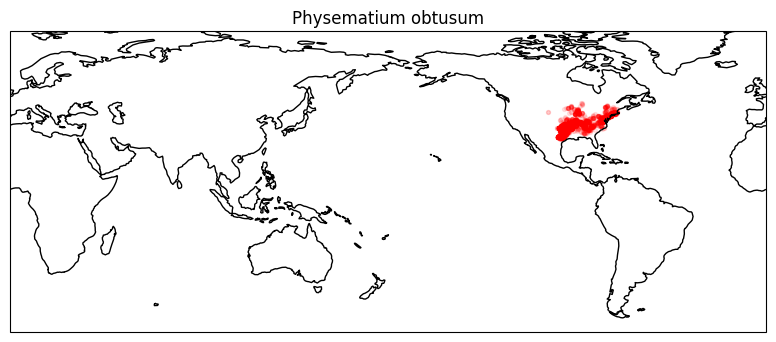

<Figure size 640x480 with 0 Axes>

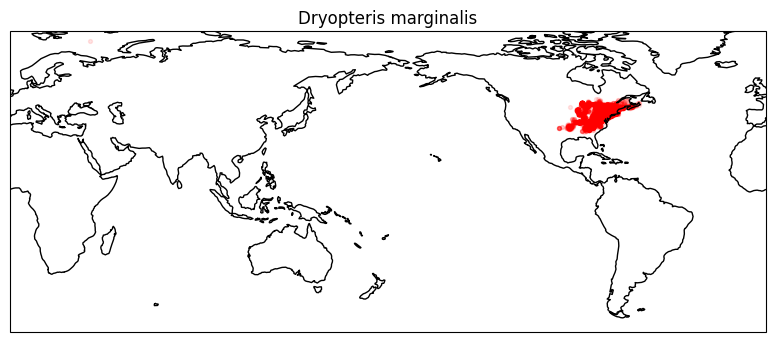

<Figure size 640x480 with 0 Axes>

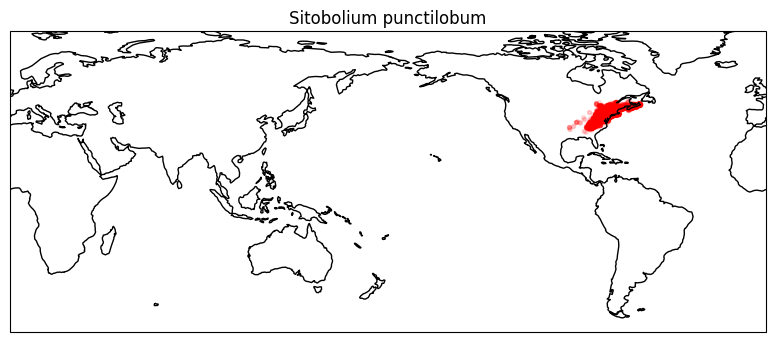

In [22]:
dd = dd.sort_values(by="cor_dim")

for j in [0, 1, -2, -1]:
    map_species(dd.index[j])

Below we use principal component analysis to understand the variation of the eCDF's.

In [23]:
species = dd.index.tolist()
dm = np.vstack([dd.loc[k].ecdf for k in species])
dm = np.log(dm)
dmn = dm.mean(0)
dm -= dmn
u,s,vt = np.linalg.svd(dm)
v = vt.T

The spectrum seems to closely follow a power law $s_k \sim k^{-1.8}$.

1.7723075148380505

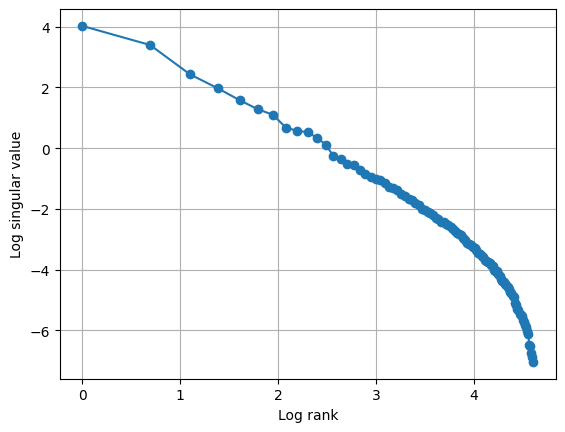

In [24]:
ii = np.arange(1, len(s)+1)
plt.plot(np.log(ii), np.log(s), "-o")
plt.grid(True)
plt.xlabel("Log rank")
plt.ylabel("Log singular value")

jj = np.flatnonzero(np.log(ii) < 3)
cc = np.cov(np.log(s[jj]), np.log(ii)[jj])
b = -cc[0, 1] / cc[1, 1]
b

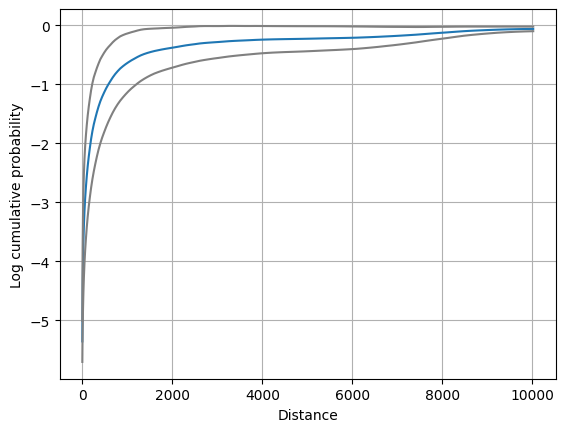

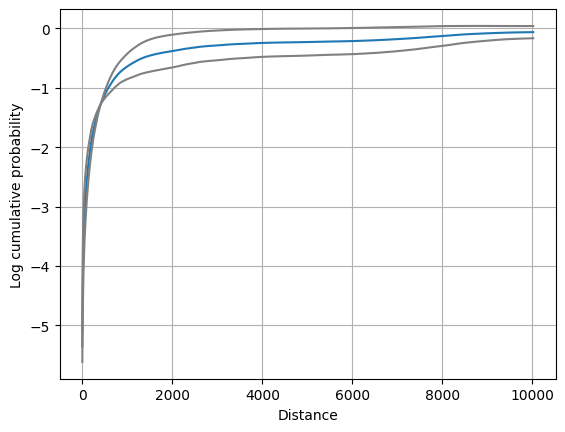

In [25]:
def plot_factor(j):
    f = s[j] * u[:, j].std()
    plt.plot(dgr, dmn)
    plt.xlabel("Distance")
    plt.ylabel("Log cumulative probability")
    plt.grid(True)
    for k in [-1, 1]:
        plt.plot(dgr, dmn + k*f*v[:, j], color="grey")
    plt.show()
        
plot_factor(0)
plot_factor(1)

Below is a scatterplot of the PC scores for the first two factors. 

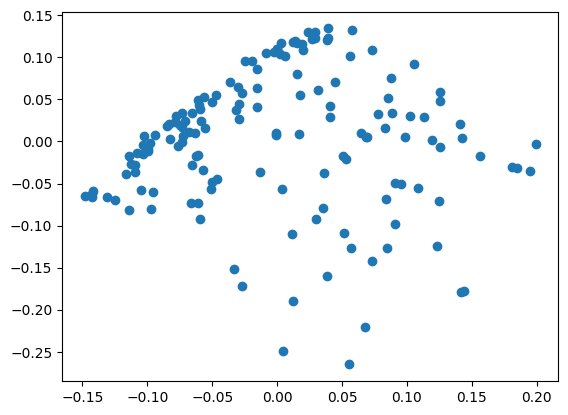

In [26]:
plt.plot(u[:, 0], u[:, 1], "o")

Below are plots of the eCDF functions (on the log scale) with extreme scores on factor 1, and on factor 2.

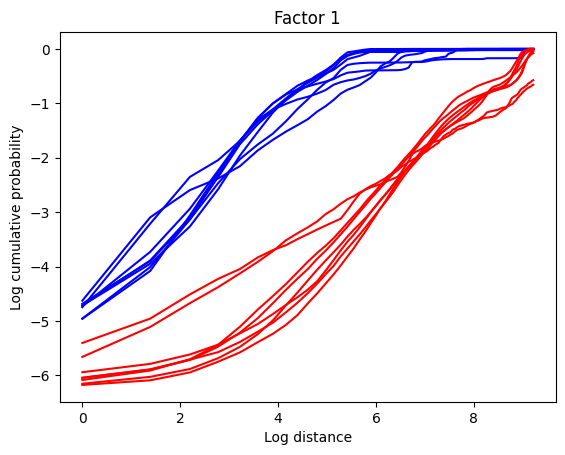

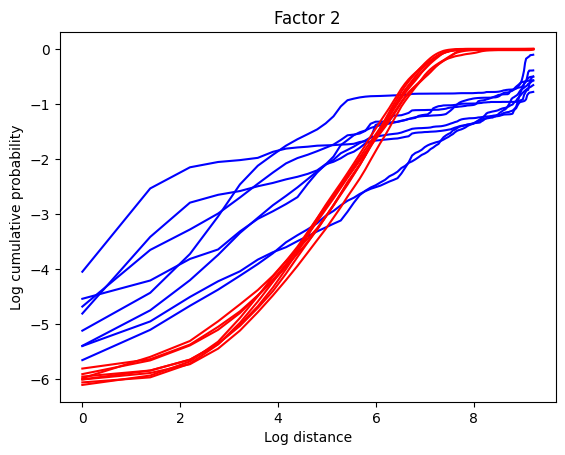

In [27]:
q0 = np.quantile(u[:, 0], [0.05, 0.95])
q1 = np.quantile(u[:, 1], [0.05, 0.95])
qq = [q0, q1]

for j in [0, 1]:
    i0 = np.flatnonzero(u[:, j] < qq[j][0])
    plt.clf()
    plt.title("Factor {}".format(j+1))
    plt.xlabel("Log distance")
    plt.ylabel("Log cumulative probability")
    for i in i0:
        plt.plot(np.log(dgr), np.log(dd["ecdf"].iloc[i]), "-", color="blue")
    
    i1 = np.flatnonzero(u[:, j] > qq[j][1])
    for i in i1:
        plt.plot(np.log(dgr), np.log(dd["ecdf"].iloc[i]), "-", color="red")
    plt.show()


The eCDF of pairwise distances is closely related to [Ripley's K-function](https://en.wikipedia.org/wiki/Spatial_descriptive_statistics) and the closely related Ripley's L-function.

The K-function is the eCDF times the area of the region containing the points.  Under a uniform distribution, the k-function will be $\pi d^2$.  However no plant is even close to being uniformly distributed on the Earth's surface (not least because of the presence of oceans), so this is really a "straw man" hypothesis. 

If the K-function is equal to $\pi d^2$, then the log of the K-function is a linear function of $\log(d)$, with slope 2.  As seen above, no species has a slope approaching 2.

For the sake of illustration, we can take the area to be the total land area on Earth, excluding Antarctica. 

If $K(d)$ is the K-function, then the L-function is $L(d) = (K(d)/\pi)^{1/2}$.  This is done to achieve variance stabilization.  Plotting $d - L(d)$ against $d$ should give a point set with zero conditional mean and constant conditional variance under uniformity.  We present a few such plots below, and see extreme discrepancy from what would be expected under uniformity.

Text(0, 0.5, 'Log fraction of pairwise distances')

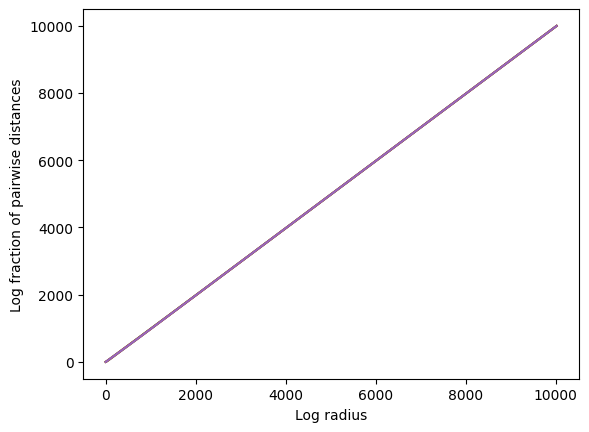

In [28]:
for j in np.random.choice(dd.shape[0], 5):
    plt.plot(dgr, dgr - np.sqrt(land_area*dd["ecdf"].iloc[j] / np.pi), "-")
plt.xlabel("Log radius")
plt.ylabel("Log fraction of pairwise distances")

To check that we are using these methods properly, below we simulate data from a uniform distribution on the sphere and calculate the empirical CDF of the pairwise distances.  First we simulate the data:

Text(0, 0.5, 'Y')

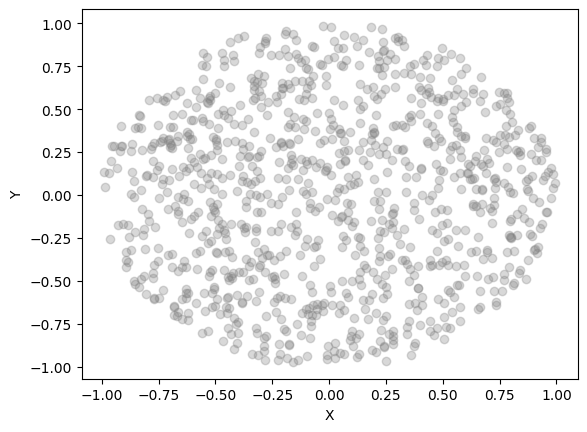

In [29]:
n = 1000
theta = 2 * np.pi * np.random.uniform(size=n)
r = np.sqrt(np.random.uniform(size=n))
x = r*np.sin(theta)
y = r*np.cos(theta)
xy = np.vstack((x, y)).T
plt.plot(x, y, "o", color="grey", alpha=0.3)
plt.xlabel("X")
plt.ylabel("Y")

Next we calculate the empirical CDF and assess that it is a quadratic function of distance:

In [30]:
d = distance_matrix(xy, xy)
ii = np.tril_indices(n)
di = d[ii]
di.sort()
g = np.linspace(0, 1, 100)
pp = np.searchsorted(di, g) / len(di)

The CDF should be a quadratic function of distance, this can be assessed based on whether the plot below has a slope of 2:

/var/folders/1m/g_2xpnh912g613fymwqbt4gr0000gn/T/ipykernel_52894/1038186383.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(g), np.log(pp), "o")


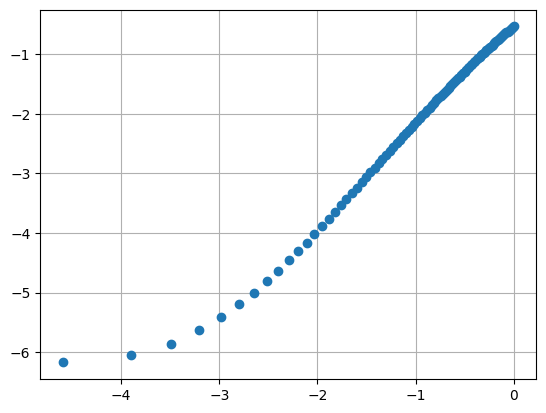

In [31]:
plt.grid(True)
plt.plot(np.log(g), np.log(pp), "o")

Another check is that the K function should be equal to $d^2$, which is true up until $d$ gets large enough that there are boundary effects.

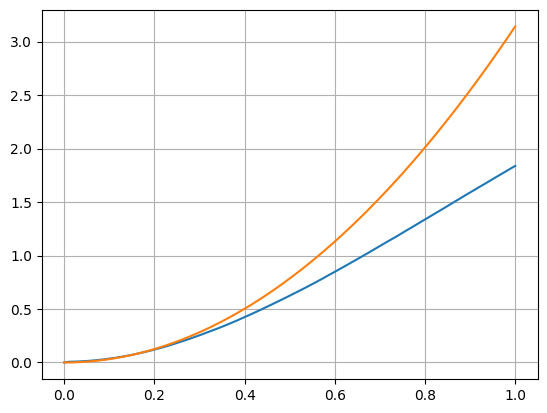

In [32]:
plt.grid(True)
plt.plot(g, np.pi*pp)
plt.plot(g, np.pi*g**2)